In [1]:
%load_ext autoreload
%load_ext blackcellmagic
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import glob
import pickle

from nmf_ik.utils import dict_to_nparray_pose, save_file
from nmf_ik.data import BOUNDS, NMF_SIZE, NMF_TEMPLATE, INITIAL_ANGLES
from nmf_ik.leg_inverse_kinematics import LegInverseKinematics

DATA_PATH = Path(
    "../data/nmf_walking_data_fly1"
)

# Next two data come from the paper
aligned_pose_pp = pd.read_pickle(
    DATA_PATH / "pose_result__210902_PR_Fly1_aligned.pkl"
)

joint_angles_pp = pd.read_pickle(
    DATA_PATH / "joint_angles__210902_PR_Fly1.pkl"
)

ANGLES = [
    "ThC_yaw",
    "ThC_pitch",
    "ThC_roll",
    "CTr_pitch",
    "CTr_roll",
    "FTi_pitch",
    "TiTa_pitch",
]

## Dictionary conversion

In [19]:
# Aligned pose now in a nested dictionary format. -> dictionary[leg_name][key_point_name][raw_pos_aligned]
# My package is using numpy arrays, so we convert the pose dictionary into a compatible format

print(aligned_pose_pp.keys())

converted_aligned_pose = {}

for leg_name, leg_pose_data in aligned_pose_pp.items():
    converted_aligned_pose[leg_name] = dict_to_nparray_pose(
        leg_pose_data, claw_is_end_effector=True
    )

dict_keys(['RF_leg', 'RM_leg', 'RH_leg', 'LF_leg', 'LM_leg', 'LH_leg'])


In [23]:
print(converted_aligned_pose.keys())

converted_aligned_pose['RF_leg'].shape # timestep, key points, coordinates (x,y,z)

dict_keys(['RF_leg', 'RM_leg', 'RH_leg', 'LF_leg', 'LM_leg', 'LH_leg'])


(1000, 5, 3)

In [51]:
# let's save the new dictionary
save_file(DATA_PATH / 'pose3d_aligned.pkl', converted_aligned_pose)

## Using sequential Inverse Kinematics

In [47]:
# Now we converted the aligned pose from nested dictionary to numpy arrays.
# Let's start using seq_ik

# Step 1: alignment - already done so we can skip

"""
align = AlignPose(DATA_PATH, pts2align=PTS2ALIGN, nmf_template=NMF_TEMPLATE)
aligned_pos = align.align_pose(
    save_pose_file=True,
)
"""

# Step 2. calculation of joint angles
# Note that we don't have joint DOF bounds for middle and hind legs
# Let's define something arbitrary for them just for now. 

BOUNDS_NEW = {
    "RF_ThC_roll": (np.deg2rad(-130), np.deg2rad(-5)),
    "RF_ThC_yaw": (np.deg2rad(-10), np.deg2rad(60)),
    "RF_ThC_pitch": (np.deg2rad(-40), np.deg2rad(60)),
    "RF_CTr_pitch": (np.deg2rad(-180), np.deg2rad(-20)),
    "RF_CTr_roll": (np.deg2rad(-150), np.deg2rad(20)),
    "RF_FTi_pitch": (np.deg2rad(0), np.deg2rad(170)),
    "RF_TiTa_pitch": (np.deg2rad(-100), np.deg2rad(0)),
    "LF_ThC_roll": (np.deg2rad(5), np.deg2rad(130)),
    "LF_ThC_yaw": (np.deg2rad(-60), np.deg2rad(10)),
    "LF_ThC_pitch": (np.deg2rad(-40), np.deg2rad(60)),
    "LF_CTr_pitch": (np.deg2rad(-180), np.deg2rad(-20)),
    "LF_CTr_roll": (np.deg2rad(20), np.deg2rad(150)),
    "LF_FTi_pitch": (np.deg2rad(0), np.deg2rad(170)),
    "LF_TiTa_pitch": (np.deg2rad(-100), np.deg2rad(0)),

    "RM_ThC_roll": (np.deg2rad(-130), np.deg2rad(-5)),
    "RM_ThC_yaw": (np.deg2rad(-10), np.deg2rad(60)),
    "RM_ThC_pitch": (np.deg2rad(-40), np.deg2rad(60)),
    "RM_CTr_pitch": (np.deg2rad(-180), np.deg2rad(-20)),
    "RM_CTr_roll": (np.deg2rad(-150), np.deg2rad(20)),
    "RM_FTi_pitch": (np.deg2rad(0), np.deg2rad(170)),
    "RM_TiTa_pitch": (np.deg2rad(-100), np.deg2rad(0)),
    "LM_ThC_roll": (np.deg2rad(5), np.deg2rad(130)),
    "LM_ThC_yaw": (np.deg2rad(-60), np.deg2rad(10)),
    "LM_ThC_pitch": (np.deg2rad(-40), np.deg2rad(60)),
    "LM_CTr_pitch": (np.deg2rad(-180), np.deg2rad(-20)),
    "LM_CTr_roll": (np.deg2rad(20), np.deg2rad(150)),
    "LM_FTi_pitch": (np.deg2rad(0), np.deg2rad(170)),
    "LM_TiTa_pitch": (np.deg2rad(-100), np.deg2rad(0)),

    "RH_ThC_roll": (np.deg2rad(-130), np.deg2rad(-5)),
    "RH_ThC_yaw": (np.deg2rad(-10), np.deg2rad(60)),
    "RH_ThC_pitch": (np.deg2rad(-40), np.deg2rad(60)),
    "RH_CTr_pitch": (np.deg2rad(-180), np.deg2rad(-20)),
    "RH_CTr_roll": (np.deg2rad(-150), np.deg2rad(20)),
    "RH_FTi_pitch": (np.deg2rad(0), np.deg2rad(170)),
    "RH_TiTa_pitch": (np.deg2rad(-100), np.deg2rad(0)),
    "LH_ThC_roll": (np.deg2rad(5), np.deg2rad(130)),
    "LH_ThC_yaw": (np.deg2rad(-60), np.deg2rad(10)),
    "LH_ThC_pitch": (np.deg2rad(-40), np.deg2rad(60)),
    "LH_CTr_pitch": (np.deg2rad(-180), np.deg2rad(-20)),
    "LH_CTr_roll": (np.deg2rad(20), np.deg2rad(150)),
    "LH_FTi_pitch": (np.deg2rad(0), np.deg2rad(170)),
    "LH_TiTa_pitch": (np.deg2rad(-100), np.deg2rad(0)),
}

# Same for initial guesses 

INITIAL_ANGLES_NEW = {
    "RF": {
        "stage_1": np.array([0.0, 0.45, 0.37, -2.14]),
        "stage_2": np.array([0.0, -0.32, 0.45, 0.37, -2.14, 1.4]),
        "stage_3": np.array([0.0, -0.32, 0.45, 0.37, -2.14, -1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, -0.32, 0.45, 0.37, -2.14, -1.25, 1.48, 0.0, 0.0]),
    },

    "LF": {
        "stage_1": np.array([0.0, -0.45, 0.37, -2.14]),
        "stage_2": np.array([0.0, 0.32, -0.45, 0.37, -2.14, 1.4]),
        "stage_3": np.array([0.0, 0.32, -0.45, 0.37, -2.14, 1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, 0.32, -0.45, 0.37, -2.14, 1.25, 1.48, 0.0, 0.0]),
    },

    "RM": {
        "stage_1": np.array([0.0, 0.45, 0.37, -2.14]),
        "stage_2": np.array([0.0, -0.32, 0.45, 0.37, -2.14, 1.4]),
        "stage_3": np.array([0.0, -0.32, 0.45, 0.37, -2.14, -1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, -0.32, 0.45, 0.37, -2.14, -1.25, 1.48, 0.0, 0.0]),
    },

    "LM": {
        "stage_1": np.array([0.0, -0.45, 0.37, -2.14]),
        "stage_2": np.array([0.0, 0.32, -0.45, 0.37, -2.14, 1.4]),
        "stage_3": np.array([0.0, 0.32, -0.45, 0.37, -2.14, 1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, 0.32, -0.45, 0.37, -2.14, 1.25, 1.48, 0.0, 0.0]),
    },

    "RH": {
        "stage_1": np.array([0.0, 0.45, 0.37, -2.14]),
        "stage_2": np.array([0.0, -0.32, 0.45, 0.37, -2.14, 1.4]),
        "stage_3": np.array([0.0, -0.32, 0.45, 0.37, -2.14, -1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, -0.32, 0.45, 0.37, -2.14, -1.25, 1.48, 0.0, 0.0]),
    },

    "LH": {
        "stage_1": np.array([0.0, -0.45, 0.37, -2.14]),
        "stage_2": np.array([0.0, 0.32, -0.45, 0.37, -2.14, 1.4]),
        "stage_3": np.array([0.0, 0.32, -0.45, 0.37, -2.14, 1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, 0.32, -0.45, 0.37, -2.14, 1.25, 1.48, 0.0, 0.0]),
    },

    "head": np.array([0, -0.17, 0]),  #  none, roll, pitch, yaw
}

# Let's run the seq IK.. This will take a while... (~20 mins)

class_seq_ik = LegInverseKinematics(
    aligned_pos=converted_aligned_pose, # our aligned pose
    bounds=BOUNDS_NEW, # bound of joint DOFs
    nmf_size=NMF_SIZE,
    initial_angles=INITIAL_ANGLES_NEW, # initial guess for the joint angles (does not matter as long as their in the BOUNDs range)
)

# This will save two separate files: 
# `leg_joint_angles.pkl` -> pickle file that containes the leg joint angles 
# `forward_kinematics.pkl` -> 3D position of the legs construction from the calculated leg joint angles
# The latter is useful for debugging, visualization...
leg_joint_angles, forward_kinematics = class_seq_ik.run_ik_and_fk(export_path=DATA_PATH) # where the results will be saved

2023-02-27 08:18:58,003 - INFO- Calculating joint angles and forward kinematics...


KeyboardInterrupt: 

In [39]:
print(leg_joint_angles.keys())

dict_keys(['Angle_RF_ThC_yaw', 'Angle_RF_ThC_pitch', 'Angle_RF_ThC_roll', 'Angle_RF_CTr_pitch', 'Angle_RF_CTr_roll', 'Angle_RF_FTi_pitch', 'Angle_RF_TiTa_pitch', 'Angle_RM_ThC_yaw', 'Angle_RM_ThC_pitch', 'Angle_RM_ThC_roll', 'Angle_RM_CTr_pitch', 'Angle_RM_CTr_roll', 'Angle_RM_FTi_pitch', 'Angle_RM_TiTa_pitch', 'Angle_RH_ThC_yaw', 'Angle_RH_ThC_pitch', 'Angle_RH_ThC_roll', 'Angle_RH_CTr_pitch', 'Angle_RH_CTr_roll', 'Angle_RH_FTi_pitch', 'Angle_RH_TiTa_pitch', 'Angle_LF_ThC_yaw', 'Angle_LF_ThC_pitch', 'Angle_LF_ThC_roll', 'Angle_LF_CTr_pitch', 'Angle_LF_CTr_roll', 'Angle_LF_FTi_pitch', 'Angle_LF_TiTa_pitch', 'Angle_LM_ThC_yaw', 'Angle_LM_ThC_pitch', 'Angle_LM_ThC_roll', 'Angle_LM_CTr_pitch', 'Angle_LM_CTr_roll', 'Angle_LM_FTi_pitch', 'Angle_LM_TiTa_pitch', 'Angle_LH_ThC_yaw', 'Angle_LH_ThC_pitch', 'Angle_LH_ThC_roll', 'Angle_LH_CTr_pitch', 'Angle_LH_CTr_roll', 'Angle_LH_FTi_pitch', 'Angle_LH_TiTa_pitch'])


## 2D visualization

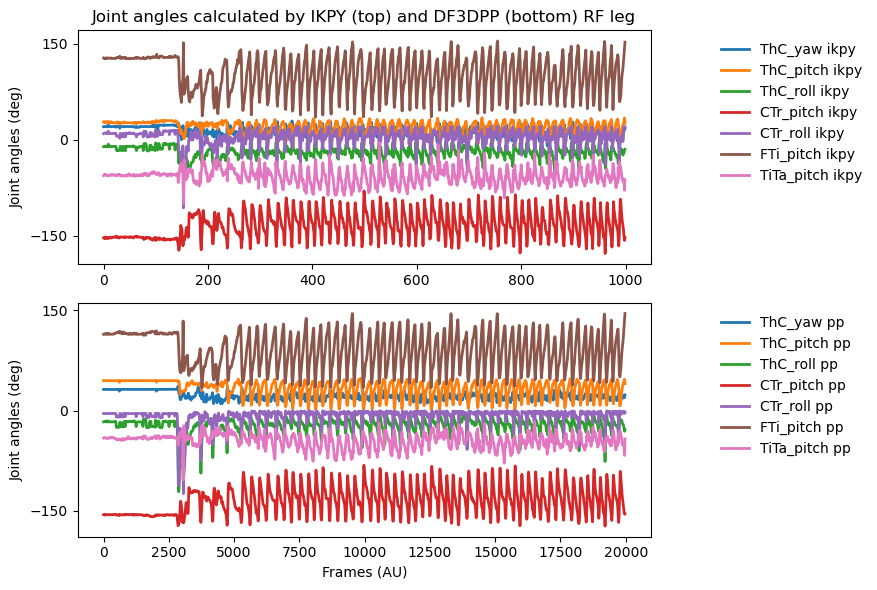

In [42]:
# Let's plot the joint angles
# Choose a leg
leg = "RF"

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), dpi=100)


for angle_name in ANGLES:
    ax1.plot(
        np.rad2deg(leg_joint_angles[f"Angle_{leg}_{angle_name}"]),
        label=angle_name + " ikpy",
        lw=2,
    )
    ax2.plot(
        np.rad2deg(joint_angles_pp[f"{leg}_leg"][angle_name]),
        label=angle_name + " pp",
        lw=2,
    )

ax1.set_ylabel("Joint angles (deg)")
ax2.set_ylabel("Joint angles (deg)")
# axs[2].set_ylabel("Ant pitch (deg)")
# axs[3].set_ylabel("Ant roll (deg)")

ax2.set_xlabel("Frames (AU)")

ax1.legend(bbox_to_anchor=(1.1, 1), frameon=False)
ax2.legend(bbox_to_anchor=(1.1, 1), frameon=False)

ax1.set_title(f"Joint angles calculated by IKPY (top) and DF3DPP (bottom) {leg} leg")
ax1.set_yticks([-150, 0, 150])
ax2.set_yticks([-150, 0, 150])

plt.tight_layout()

# fig.savefig("../results/alljoints_follow_ikpy_left.png", bbox_inches="tight")

plt.show()

Note that for foreleg joint angles, the method is not bad. For middle and hind legs, however, the ThC yaw and pitch are calculated differently. Change matplotlob back-end to notebook using %matplotlib notebook in the beginning of the cell to have an interactive plot, and zoom in ThC yaw and pitch: ***you will see flat lines***.

What does it mean? It means that ***optimization wants to go out of the bonds to satisfy the end effector position however the bounds are too restrictive, which makes sense, given the bounds were originally designed for antennal grooming (a totally different behavior).*** 

What does it mean? It means that you need to do further adjustments to the joint angle bounds for locomotion :)

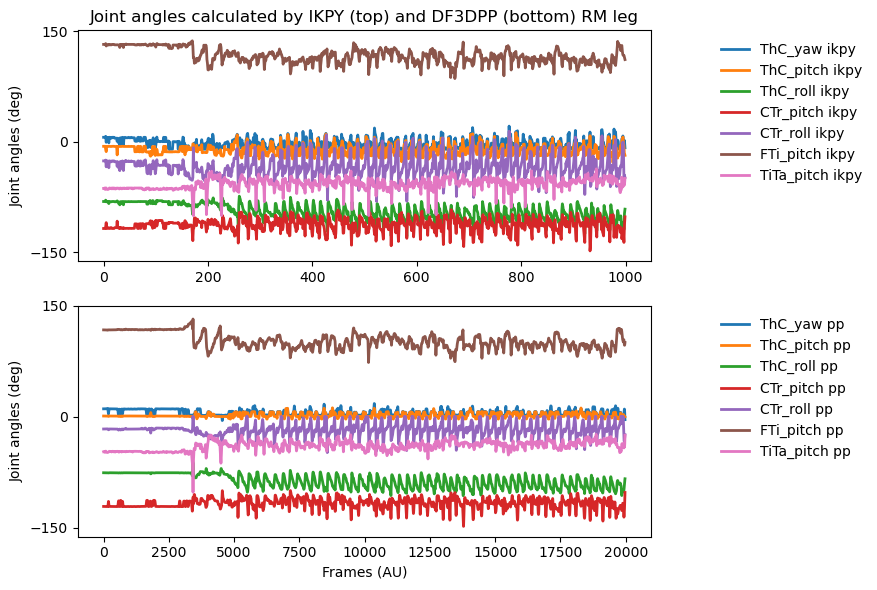

In [46]:
%matplotlib inline
# Let's plot the joint angles
# Choose a leg
leg = "RM"

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), dpi=100)


for angle_name in ANGLES:
    ax1.plot(
        np.rad2deg(leg_joint_angles[f"Angle_{leg}_{angle_name}"]),
        label=angle_name + " ikpy",
        lw=2,
    )
    ax2.plot(
        np.rad2deg(joint_angles_pp[f"{leg}_leg"][angle_name]),
        label=angle_name + " pp",
        lw=2,
    )

ax1.set_ylabel("Joint angles (deg)")
ax2.set_ylabel("Joint angles (deg)")
# axs[2].set_ylabel("Ant pitch (deg)")
# axs[3].set_ylabel("Ant roll (deg)")

ax2.set_xlabel("Frames (AU)")

ax1.legend(bbox_to_anchor=(1.1, 1), frameon=False)
ax2.legend(bbox_to_anchor=(1.1, 1), frameon=False)

ax1.set_title(f"Joint angles calculated by IKPY (top) and DF3DPP (bottom) {leg} leg")
ax1.set_yticks([-150, 0, 150])
ax2.set_yticks([-150, 0, 150])

plt.tight_layout()

# fig.savefig("../results/alljoints_follow_ikpy_left.png", bbox_inches="tight")

plt.show()

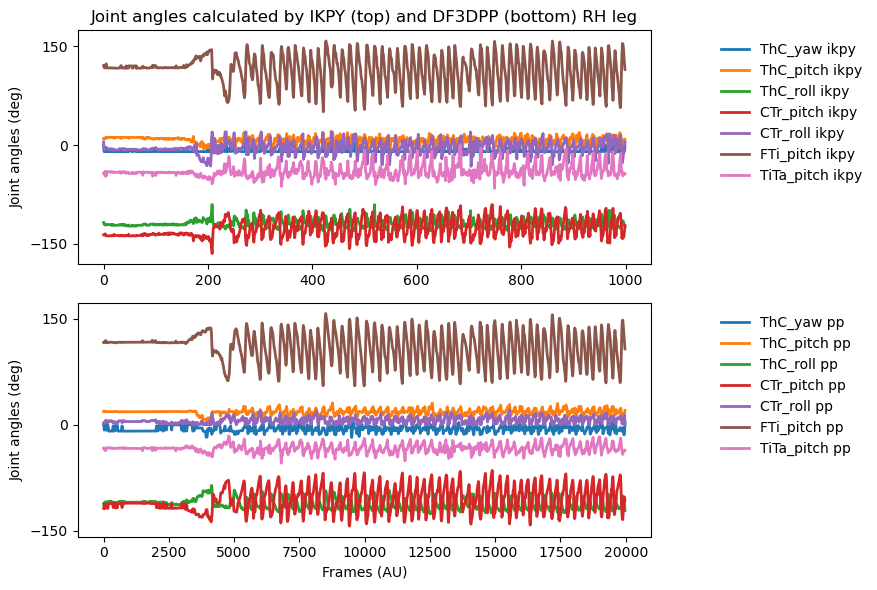

In [44]:
# Let's plot the joint angles
# Choose a leg
leg = "RH"

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), dpi=100)


for angle_name in ANGLES:
    ax1.plot(
        np.rad2deg(leg_joint_angles[f"Angle_{leg}_{angle_name}"]),
        label=angle_name + " ikpy",
        lw=2,
    )
    ax2.plot(
        np.rad2deg(joint_angles_pp[f"{leg}_leg"][angle_name]),
        label=angle_name + " pp",
        lw=2,
    )

ax1.set_ylabel("Joint angles (deg)")
ax2.set_ylabel("Joint angles (deg)")
# axs[2].set_ylabel("Ant pitch (deg)")
# axs[3].set_ylabel("Ant roll (deg)")

ax2.set_xlabel("Frames (AU)")

ax1.legend(bbox_to_anchor=(1.1, 1), frameon=False)
ax2.legend(bbox_to_anchor=(1.1, 1), frameon=False)

ax1.set_title(f"Joint angles calculated by IKPY (top) and DF3DPP (bottom) {leg} leg")
ax1.set_yticks([-150, 0, 150])
ax2.set_yticks([-150, 0, 150])

plt.tight_layout()

# fig.savefig("../results/alljoints_follow_ikpy_left.png", bbox_inches="tight")

plt.show()

## 3D visualization

See scripts for more information.

In [57]:
points_aligned_all.shape

(1000, 30, 3)

2023-02-27 08:45:51,178 - INFO- Making animation...
2023-02-27 08:45:51,179 - INFO- Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-02-27 08:45:51,181 - INFO- MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1800x1200 -pix_fmt rgba -r 100 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ../data/nmf_walking_data_fly1/inverse_kinematics_results_front.mp4
2023-02-27 08:46:34,819 - INFO- Animation is saved at ../data/nmf_walking_data_fly1/inverse_kinematics_results_front.mp4


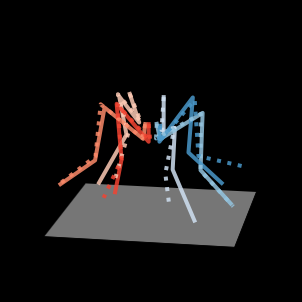

In [62]:
#### from nmf_ik.visualization import animate_3d_points
fps = 100

pose3d = DATA_PATH / "pose3d_aligned.pkl"
forward_kinematics = DATA_PATH / "forward_kinematics.pkl"
out_dir = DATA_PATH / f"inverse_kinematics_results_front.mp4"

with open(pose3d, "rb") as f:
    aligned_pose = pickle.load(f)
with open(forward_kinematics, "rb") as f:
    forward_kin = pickle.load(f)

points_aligned_all = np.concatenate(
    (
        aligned_pose["RF_leg"],
        aligned_pose["RM_leg"],
        aligned_pose["RH_leg"],
        aligned_pose["LF_leg"],
        aligned_pose["LM_leg"],
        aligned_pose["LH_leg"],
    ),
    axis=1,
)

points_fk = np.concatenate(
    (
        forward_kin["RF_leg"],
        forward_kin["RM_leg"],
        forward_kin["RH_leg"],
        forward_kin["LF_leg"],
        forward_kin["LM_leg"],
        forward_kin["LH_leg"],        
    ),
    axis=1,
)

KEY_POINTS_DICT = {
    "RF": (np.arange(0, 5), "solid"),
    "RM": (np.arange(5, 10), "solid"),
    "RH": (np.arange(10, 15), "solid"),
    "LF": (np.arange(15, 20), "solid"),
    "LM": (np.arange(20, 25), "solid"),
    "LH": (np.arange(25, 30), "solid"),
}

KEY_POINTS_DICT2 = {
    "RF": (np.arange(0, 9), ":"),
    "RM": (np.arange(9, 18), ":"),
    "RH": (np.arange(18, 27), ":"),
    "LF": (np.arange(27, 36), ":"),
    "LM": (np.arange(36, 45), ":"),
    "LH": (np.arange(45, 54), ":"),
}

animate_3d_points(
    points_aligned_all,
    KEY_POINTS_DICT,
    points3d_second=points_fk,
    key_points_second=KEY_POINTS_DICT2,
    export_path=out_dir,
    frame_no=1000,
    elev=15,
    azim=10,
)
